# Forecasting Delays in the Swiss Transportation System

## Final Data-Processing & Hyperparameters Fine Tuning

Copyrights © 2025, 2026 Yvan Richard.  
All rights reserved.

## Foreword

In this notebook, I pre-processed my data and fine tune my selected model: `HistGradientBoostingClassifier`.

## 1. Load the Data

I load the data without the weather features:

In [10]:
# load the data frame from january
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the data frame from january features
df_jan = pd.read_parquet("../../data/features/ist_features_2025_01.parquet")

# drop rows with missing values
n1 = len(df_jan)
df_jan = df_jan.dropna()
n2 = len(df_jan)
print(f"Dropped {(n1 - n2) / n1 * 100:.2f}% rows with missing values.")

# head
df_jan.head()

Dropped 2.89% rows with missing values.


,op_date,trip_id,stop_id,stop_name,line_name,vehicle_type,additional_trip,arrival_scheduled_dt,arrival_observed_dt,arrival_delay_minutes,...,vt_RJX,vt_S,vt_SN,vt_TER,vt_TGV,latitude,longitude,connection_density,running_trip_delay,mean_stop_delay
1,2025-01-03,ch:1:sjyid:100001:19220-001,8506013,Aadorf,S12,S,false,2025-01-03 05:31:00,2025-01-03 05:30:55,-0.083333,...,False,True,False,False,False,47.488118,8.903301,35,0.150000,1.216667
2,2025-01-03,ch:1:sjyid:100001:19219-002,8506013,Aadorf,S12,S,false,2025-01-03 06:28:00,2025-01-03 06:28:41,0.683333,...,False,True,False,False,False,47.488118,8.903301,35,0.577778,0.566667
3,2025-01-03,ch:1:sjyid:100001:19224-001,8506013,Aadorf,S12,S,false,2025-01-03 06:31:00,2025-01-03 06:31:04,0.066667,...,False,True,False,False,False,47.488118,8.903301,35,0.994444,0.605556
4,2025-01-03,ch:1:sjyid:100001:19223-002,8506013,Aadorf,S12,S,false,2025-01-03 07:28:00,2025-01-03 07:29:28,1.466667,...,False,True,False,False,False,47.488118,8.903301,35,2.272222,0.375000
5,2025-01-03,ch:1:sjyid:100001:19228-001,8506013,Aadorf,S12,S,false,2025-01-03 07:31:00,2025-01-03 07:31:08,0.133333,...,False,True,False,False,False,47.488118,8.903301,35,0.866667,0.738889


## 2. Data-Processing

In this section, I develop a final data processing pipeline that will take as input `df_jan` and output `X_train`, as well as `y_train`.

### 2.1. Outliers in Arrival Delays

In this section, I observe if I have a lot of outliers in the numerical target variable.

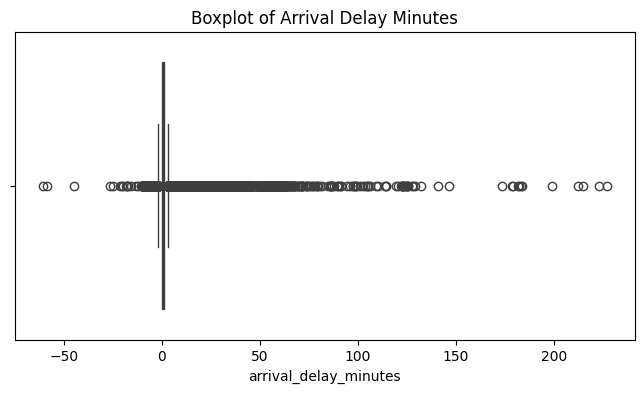

In [11]:
# outliers in arrival_delay_minutes
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x=df_jan["arrival_delay_minutes"], ax=ax)
ax.set_title("Boxplot of Arrival Delay Minutes")
plt.show()

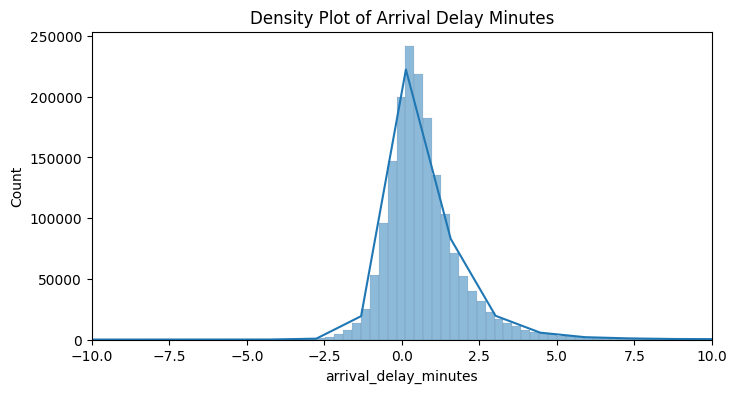

In [12]:
# density plot of arrival_delay_minutes
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(df_jan["arrival_delay_minutes"], bins=1000, kde=True, ax=ax)
ax.set_title("Density Plot of Arrival Delay Minutes")
ax.set_xlim(-10, 10) # limit x-axis for better visualization and ignore extreme outliers
plt.show()

The picture is pretty clear here, most of the train are one time and if they are delayed, they are by a small margin. However, here and there we observe extreme outliers.

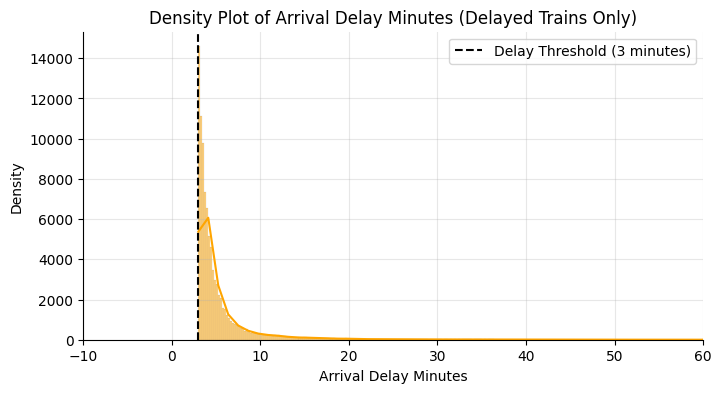

In [24]:
# conditional distribution of arrival_delay_minutes by is_delayed
subset = df_jan[df_jan["is_delayed"] == 1]['arrival_delay_minutes']

# density plot
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(subset, bins=1000, kde=True, ax=ax, color='orange')
ax.axvline(3, color='black', linestyle='--', label='Delay Threshold (3 minutes)')

# aesthetics
ax.set_title("Density Plot of Arrival Delay Minutes (Delayed Trains Only)")
ax.set_xlim(-10, 60) # limit x-axis for better visualization
ax.legend()
ax.set_xlabel("Arrival Delay Minutes")
ax.set_ylabel("Density")
ax.grid(alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Based on this observation, I see that I have some outliers in my data but removing those observations during training will probably not help me and could even be regarded as a mistake.

In [25]:
df_jan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1744304 entries, 1 to 1796286
Data columns (total 37 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   op_date                datetime64[ns]
 1   trip_id                object        
 2   stop_id                int64         
 3   stop_name              object        
 4   line_name              object        
 5   vehicle_type           object        
 6   additional_trip        object        
 7   arrival_scheduled_dt   datetime64[ns]
 8   arrival_observed_dt    datetime64[ns]
 9   arrival_delay_minutes  float64       
 10  is_delayed             int8          
 11  hour_of_day            int32         
 12  day_of_week            int32         
 13  is_weekend             bool          
 14  is_peak                bool          
 15  vt_AG                  bool          
 16  vt_ATZ                 bool          
 17  vt_EC                  bool          
 18  vt_EXT                 bool

### 2.2. Outliers in the Features

I look at some box plots of the features to detect features with a lot of outliers:

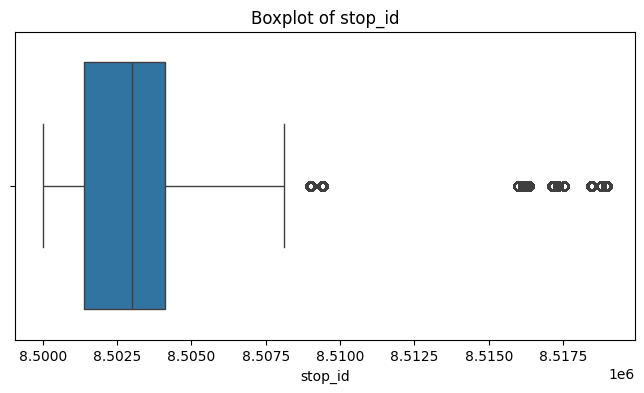

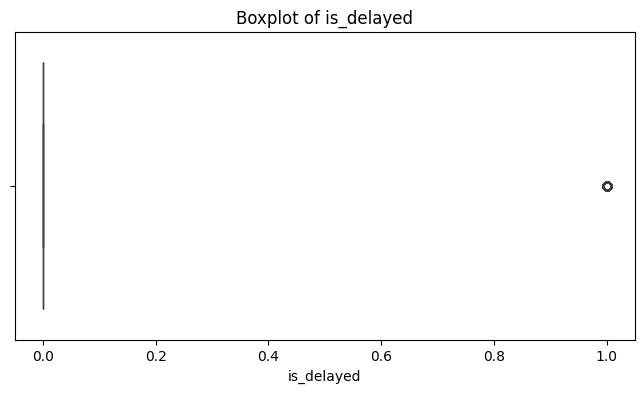

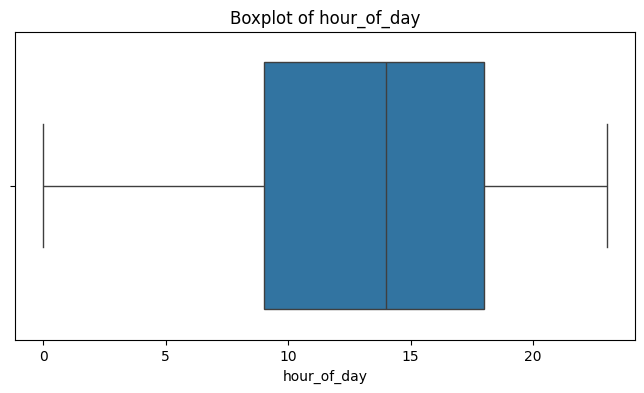

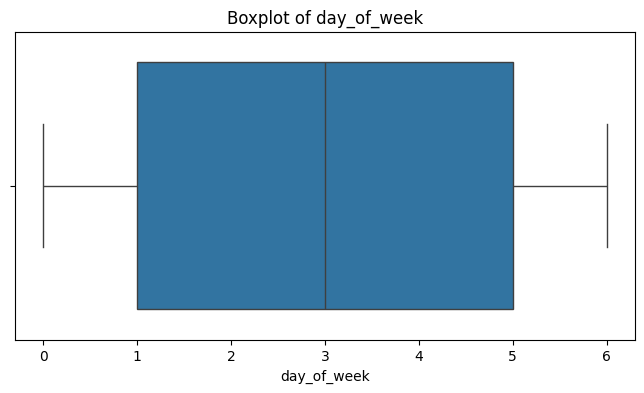

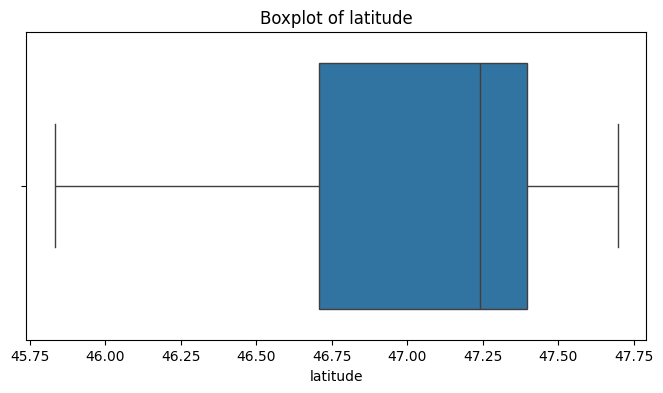

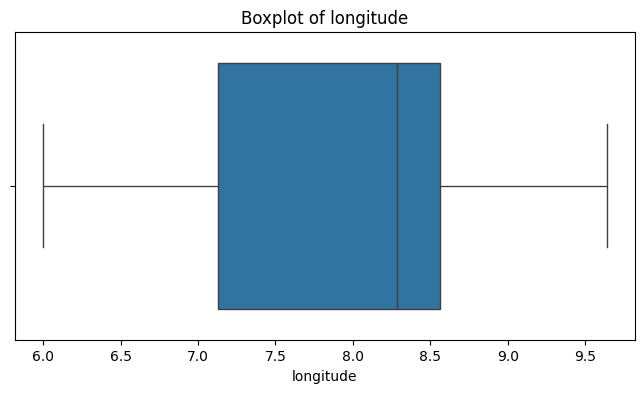

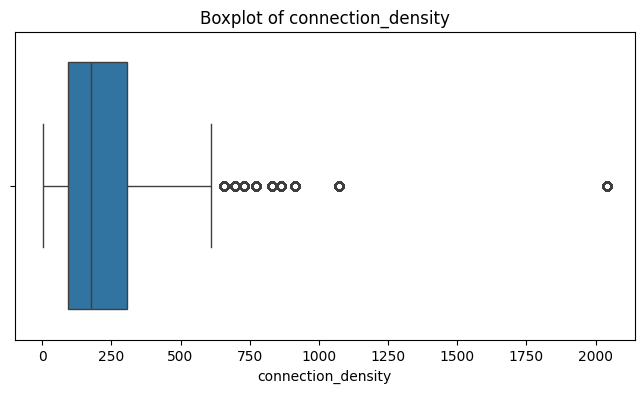

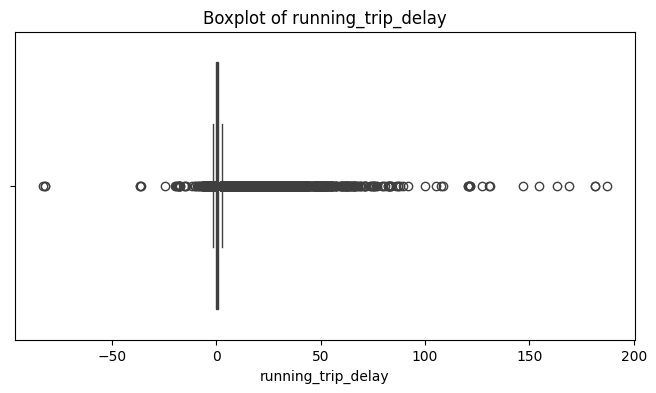

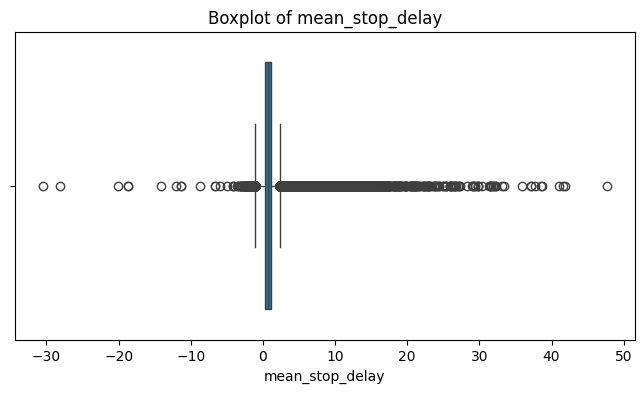

In [27]:
# boxplots of numerical features
numerical_cols = df_jan.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove("arrival_delay_minutes")  # exclude target variable

for col in numerical_cols:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=df_jan[col], ax=ax)
    ax.set_title(f"Boxplot of {col}")
    plt.show()

There is really nothing to do. The outliers in connection density are really important, the most extreme one is **Zürich HB**.

### 2.3. Final Data Pipeline

The final data pipeline is coded as:

In [29]:
def final_pipeline(df: pd.DataFrame):
    df = df.copy()

    # robust conversion for additional_trip (bool OR "true"/"false"/0/1)
    if df["additional_trip"].dtype == bool:
        df["additional_trip"] = df["additional_trip"].astype("int8")
    else:
        df["additional_trip"] = (
            df["additional_trip"]
            .astype(str).str.lower().map({"true": 1, "false": 0, "1": 1, "0": 0})
            .fillna(0).astype("int8")
        )

    # convert bool features to int
    bool_cols = df.select_dtypes(include=["bool"]).columns
    df[bool_cols] = df[bool_cols].astype("int8")

    # time sort
    df = df.sort_values("arrival_scheduled_dt").reset_index(drop=True)

    # drop NAs 
    n1 = len(df)
    df = df.dropna()
    n2 = len(df)
    print(f"Dropped {(n1 - n2) / n1 * 100:.2f}% rows with missing values.")

    # split indices
    i = int(len(df) * 0.70)
    j = int(len(df) * 0.85)

    df_train, df_val, df_test = df.iloc[:i], df.iloc[i:j], df.iloc[j:]

    # define features from TRAIN only, then align val/test
    target_cols = ["arrival_delay_minutes", "is_delayed"]
    num_train_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
    feature_cols = [c for c in num_train_cols if c not in target_cols]

    X_train = df_train[feature_cols]
    y_train = df_train["is_delayed"].astype(int)

    X_val = df_val.reindex(columns=feature_cols, fill_value=0)
    y_val = df_val["is_delayed"].astype(int)

    X_test = df_test.reindex(columns=feature_cols, fill_value=0)
    y_test = df_test["is_delayed"].astype(int)

    return X_train, y_train, X_val, y_val, X_test, y_test


Quick test of the data pipeline:

In [31]:
# test the final pipeline
X_train, y_train, X_val, y_val, X_test, y_test = final_pipeline(df_jan)

Dropped 0.00% rows with missing values.


## 3. Hyperparamters Fine-Tuning

Finally, I proceed with hyper-parameters fine-tuning for my model. Once this is ready, I will be ready to code my final pipeline and make final predictions on the test set. That will be the end of this small ML project.

In [35]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

hgb = HistGradientBoostingClassifier(random_state=42)

param_dist = {
    "learning_rate": np.logspace(np.log10(0.02), np.log10(0.2), 20),
    "max_leaf_nodes": [15, 31, 63, 127, 255],
    "min_samples_leaf": [10, 20, 50, 100, 200],
    "l2_regularization": np.logspace(-4, 1, 20),
    "max_bins": [64, 128, 255],
    "max_features": [0.5, 0.7, 0.9, 1.0],
    "early_stopping": [True],
    "validation_fraction": [0.1],
    "n_iter_no_change": [20, 30],
    "max_iter": [2000],   # let early stopping decide where to stop
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_dist,
    n_iter=60,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)  # add sample_weight=... here if needed

best_model = search.best_estimator_
print(search.best_params_)
print(search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'validation_fraction': 0.1, 'n_iter_no_change': 20, 'min_samples_leaf': 20, 'max_leaf_nodes': 255, 'max_iter': 2000, 'max_features': 0.5, 'max_bins': 255, 'learning_rate': np.float64(0.13903855923551212), 'l2_regularization': np.float64(10.0), 'early_stopping': True}
0.4702340545960178


```text
Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'validation_fraction': 0.1, 'n_iter_no_change': 20, 'min_samples_leaf': 20, 'max_leaf_nodes': 255, 'max_iter': 2000, 'max_features': 0.5, 'max_bins': 255, 'learning_rate': np.float64(0.13903855923551212), 'l2_regularization': np.float64(10.0), 'early_stopping': True}
0.4702340545960178
```